Notebook comparing simple Neural Net approach to applying Convolutional Net over the binary representation of the input

Input and output are 1d random arrays

### Imports

In [1]:
import numpy as np
import struct

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

# to track progress
from tqdm.notebook import tqdm

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### create data

In [2]:
data = np.random.rand(2000,1)
targets = np.random.rand(2000,1)

## Simple Neural Network approach

### create dataset and dataloader

In [3]:
# custom dataset class
class mydataset(Dataset):
  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.inputs[index]
    label = self.targets[index]
    return input,label
    

train_dataset = mydataset(data, targets)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

### define Net

In [4]:
class Net(nn.Module):

  def __init__(self):
      super(Net, self).__init__()
      
      self.fc1 = nn.Linear(1, 11)
      self.fc2 = nn.Linear(11, 11)
      self.fc3 = nn.Linear(11, 1)

  def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [5]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
net = Net()
print(count_parameters(net))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()

166


### train

In [7]:
def trainNet(net,criterion,optimizer,train_loader,epochs):

  print("training network")
  check_every = int(epochs/10)

  train_loss = []

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    batchTrain_loss = []
    net.train()
    for i, (inputBatch,labelBatch) in enumerate(train_loader):

      inputBatch = inputBatch.to(device).float()
      labelBatch = labelBatch.to(device).float()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      outputBatch = net(inputBatch)
      loss = criterion(outputBatch, labelBatch)
      batchTrain_loss.append(loss.item())

      # backward + optimize
      loss.backward()
      optimizer.step()

    train_loss.append(np.mean(batchTrain_loss))
    
    # print statistics
    if epoch % check_every == check_every - 1:
      print("epoch: %d  | train loss: %.5f" % (epoch + 1, np.mean(batchTrain_loss)))

  print('Finished Training')
  plt.plot(train_loss)
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.show()

training network


epoch: 5  | train loss: 0.08337
epoch: 10  | train loss: 0.08345
epoch: 15  | train loss: 0.08330
epoch: 20  | train loss: 0.08310
epoch: 25  | train loss: 0.08309
epoch: 30  | train loss: 0.08314
epoch: 35  | train loss: 0.08312
epoch: 40  | train loss: 0.08308
epoch: 45  | train loss: 0.08335
epoch: 50  | train loss: 0.08318

Finished Training


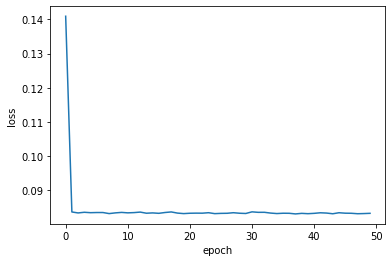

In [8]:
trainNet(net,criterion,optimizer,train_loader,50)

### evaluate

In [9]:
def evaluate(net, inputs):
  net.eval()
  output_pred = []

  with torch.no_grad():
    for input in tqdm(inputs):      
      output = net(torch.from_numpy(input).unsqueeze(0).float().to(device)).cpu().numpy()
      output_pred.append(output[0])

  return np.array(output_pred)

In [10]:
predictions = evaluate(net,data)
rmse = np.sqrt(np.mean((predictions-targets)**2))
print(rmse)


0.28860859729724625


## Convolution over bits approach

convert float to its binary IEEE 754 representation

In [11]:
def binary(num):
    bin_rpr = ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))
    bin_rpr = [int(b) for b in bin_rpr]
    return np.array(bin_rpr)

In [12]:
BinaryData = np.array( [ [binary(sample)] for sample in data ] )
print(BinaryData[0])
print(BinaryData.shape)

[[0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0]]
(2000, 1, 32)


### create dataset and dataloader

In [13]:
train_dataset = mydataset(BinaryData, targets)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

### define Net

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input channels, 5 output channels, row convolution kernel of size 5
        self.conv1 = nn.Conv1d(1, 5, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(140, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [15]:
net = Net()
print(count_parameters(net))

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

171


### train

training network


epoch: 5  | train loss: 0.08745
epoch: 10  | train loss: 0.08439
epoch: 15  | train loss: 0.08355
epoch: 20  | train loss: 0.08311
epoch: 25  | train loss: 0.08283
epoch: 30  | train loss: 0.08270
epoch: 35  | train loss: 0.08254
epoch: 40  | train loss: 0.08259
epoch: 45  | train loss: 0.08222
epoch: 50  | train loss: 0.08224

Finished Training


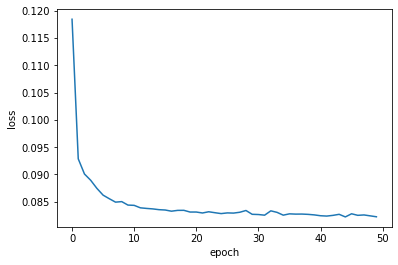

In [16]:
trainNet(net,criterion,optimizer,train_loader,50)

### evaluate

In [17]:
predictions = evaluate(net,BinaryData)
rmse = np.sqrt(np.mean((predictions-targets)**2))
print(rmse)


0.2863679803428455
